In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.loading_data.get_data import load_cv_data
from src.cnn_emos.nn_forecast import CNNEMOS, CNNBaggingEMOS
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.visualization.brier_score import make_brier_skill_plot
from src.visualization.pit import make_cpit_diagram, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness
from src.visualization.plot_forecasts import plot_forecast_pdf_tf, plot_weight_mixture_cnns
from src.climatology.climatology import Climatology
from src.linreg_emos.emos import LinearEMOS
from src.loading_data.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier

import sklearn

from scipy.stats import norm

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

### Loading all data

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data0_original, test_data0_original, ignore = load_cv_data(0, features_names_dict)

data_load = train_data0_original.batch(32)

train_data0 = train_data0_original.batch(train_data0_original.cardinality())
test_data0 = test_data0_original.batch(test_data0_original.cardinality())

In [4]:
train_data1, test_data1_original, ignore = load_cv_data(1, features_names_dict)

train_data1 = train_data1.batch(train_data1.cardinality())

test_data1 = test_data1_original.batch(test_data1_original.cardinality())


train_data2, test_data2_original, ignore = load_cv_data(2, features_names_dict)

train_data2 = train_data2.batch(train_data2.cardinality())

test_data2 = test_data2_original.batch(test_data2_original.cardinality())


train_data3, test_data3_original, ignore = load_cv_data(3, features_names_dict)

train_data3 = train_data3.batch(train_data3.cardinality())

test_data3 = test_data3_original.batch(test_data3_original.cardinality())

### Loading Climatology

In [5]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_0'

climatology = Climatology.load(folder)

### Loading All Linear Models

In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base'

with open(filepath, 'rb') as f:
    constant_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_am_tn_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate'

with open(filepath, 'rb') as f:
    sigmoid_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln = LinearEMOS(pickle.load(f))

all_linear_models_fold0 = {'LinEMOS Constant Weight TN': constant_weight_tn,
                           'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln,
                           'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,}
                           #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln}

all_linear_models_without_constant_weight0  = {'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln,
                                            'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,}
                                            #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [39]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base1'

with open(filepath, 'rb') as f:
    constant_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme1'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate1'

with open(filepath, 'rb') as f:
    sigmoid_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight1'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight1'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

all_linear_models_fold1 = {'LinEMOS Constant Weight TN': constant_weight_tn1,
                           'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln1,
                           'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn1,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,}
                           #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln1}

all_linear_models_without_constant_weight1  = {'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln1,
                                            'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn1,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,}
                                            #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln1}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [38]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base2'

with open(filepath, 'rb') as f:
    constant_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme2'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate2'

with open(filepath, 'rb') as f:
    sigmoid_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight2'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight2'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

all_linear_models_fold2 = {'LinEMOS Constant Weight TN': constant_weight_tn2,
                           'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln2,
                           'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn2,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,}
                           #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln2}

all_linear_models_without_constant_weight2  = {'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln2,
                                            'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn2,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,}
                                            #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln2}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [45]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base3'

with open(filepath, 'rb') as f:
    constant_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme3'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate3'

with open(filepath, 'rb') as f:
    sigmoid_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight3'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight3'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

all_linear_models_fold3 = {'LinEMOS Constant Weight TN': constant_weight_tn3,
                           'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln3,
                           'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn3,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,}
                           #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln3}

all_linear_models_without_constant_weight3  = {'LinEMOS Sharp Sigmoid  Weight AM TN-LN': sharp_sigmoid_weight_am_tn_ln3,
                                            'LinEMOS Sigmoid Weight TN': sigmoid_weight_tn3,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,}
                                            #'Best CNN Weight AM TN-LN': best_cnn_weight_am_tn_ln3}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


### Loading Single Model CNNs

In [49]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_1'

cnn_constant_weight_tn1 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_2'

cnn_constant_weight_tn2 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_3'

cnn_constant_weight_tn3 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_4'

cnn_constant_weight_tn4 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_5'

cnn_constant_weight_tn5 = CNNEMOS.my_load(filepath, data_load)

single_cnn_constant_weight_dict = {
    'CNNEMOS Constant Weight TN 1': cnn_constant_weight_tn1,
    'CNNEMOS Constant Weight TN 2': cnn_constant_weight_tn2,
    'CNNEMOS Constant Weight TN 3': cnn_constant_weight_tn3,
    'CNNEMOS Constant Weight TN 4': cnn_constant_weight_tn4,
    'CNNEMOS Constant Weight TN 5': cnn_constant_weight_tn5
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


### Loading Bagging CNNs



In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps'

bagging_tn_crps = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check'

bagging_tn_crps_2 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check2'

bagging_tn_crps_3 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_3.load_models(data_load)

bagging_tn_crps_models = {'Bagging TN CRPS 1': bagging_tn_crps,
                          'Bagging TN CRPS 2': bagging_tn_crps_2,
                          'Bagging TN CRPS 3': bagging_tn_crps_3}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn'

bagging_best_cnn_weight_tn = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture'

bagging_best_cnn_weight_tn_ln =  CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln.load_models(data_load)

# filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn'

# bagging_sharp_sigmoid_tn = CNNBaggingEMOS.my_load(filepath)
# bagging_sharp_sigmoid_tn.load_models(data_load)

all_bagging_models = {'Bagging Constant Weight TN': bagging_tn_crps,
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      #'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn
                      }

all_bagging_models_without_constant_weight = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      #'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


### Results on Test Data

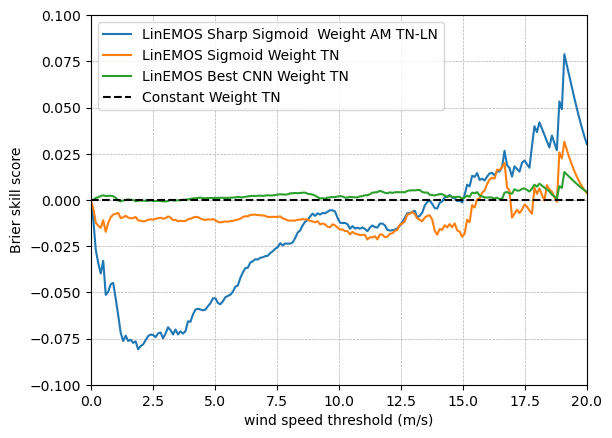

In [43]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.1]
make_brier_skill_plot(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values, ylim=ylim, name_base_model='Constant Weight TN')

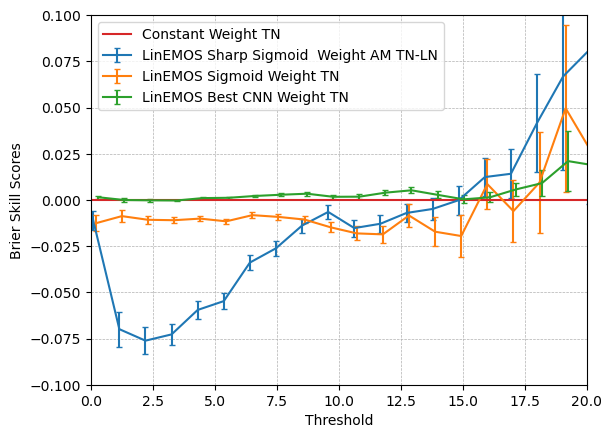

In [44]:
values = np.linspace(0,20,20)
ylim = [-0.1,0.1]
make_bootstrap_brier(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values,  ylim=ylim, name_base_model='Constant Weight TN', bootstrap_size=10000)

### Results for Cross-Validation

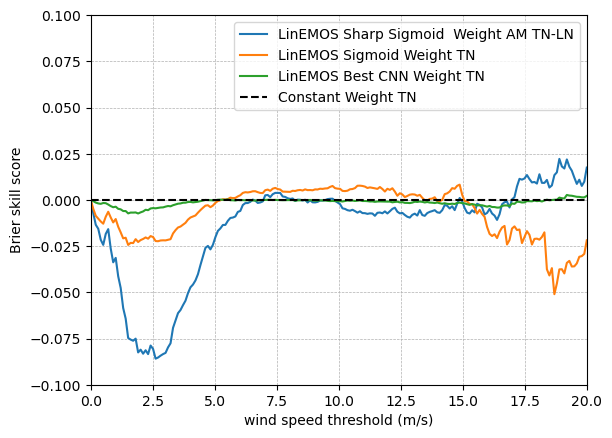

In [46]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.1]
make_brier_skill_plot(constant_weight_tn1, all_linear_models_without_constant_weight1, test_data1, values, ylim=ylim, name_base_model='Constant Weight TN')

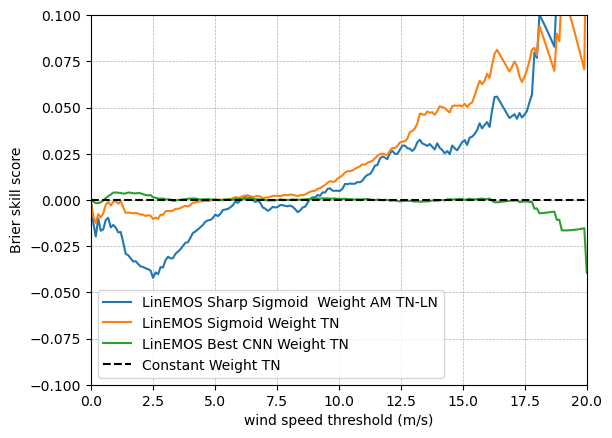

In [47]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.1]
make_brier_skill_plot(constant_weight_tn2, all_linear_models_without_constant_weight2, test_data2, values, ylim=ylim, name_base_model='Constant Weight TN')

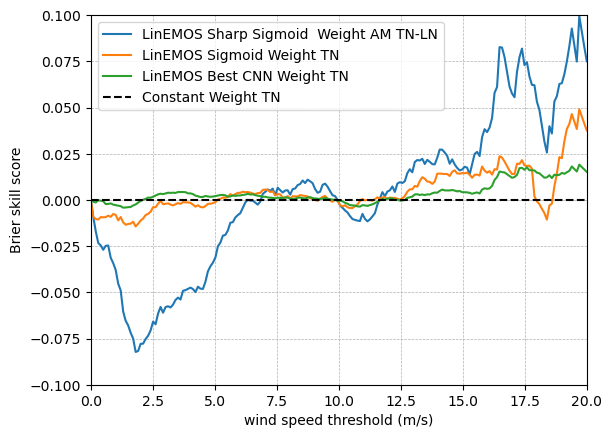

In [48]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.1]
make_brier_skill_plot(constant_weight_tn3, all_linear_models_without_constant_weight3, test_data3, values, ylim=ylim, name_base_model='Constant Weight TN')

### Results Single CNNEMOS

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


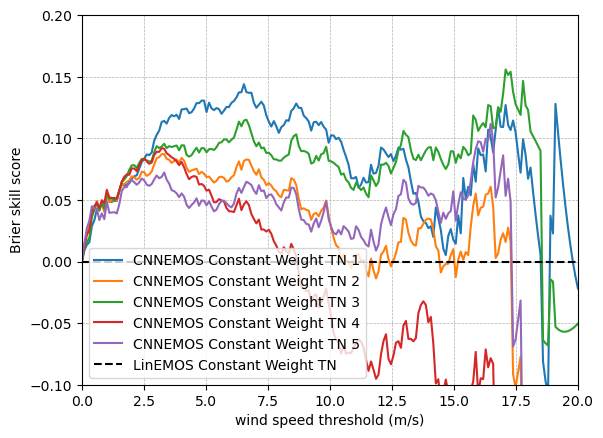

In [50]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(constant_weight_tn, single_cnn_constant_weight_dict, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

### Results Bagging

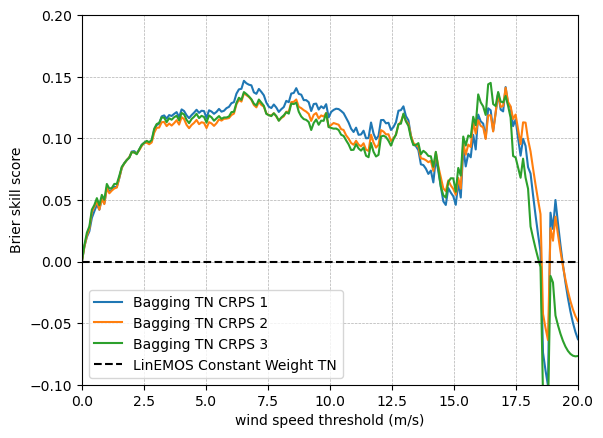

In [31]:
values = np.linspace(0,20,200)
ylim = [-0.1,0.2]
make_brier_skill_plot(constant_weight_tn, bagging_tn_crps_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')     

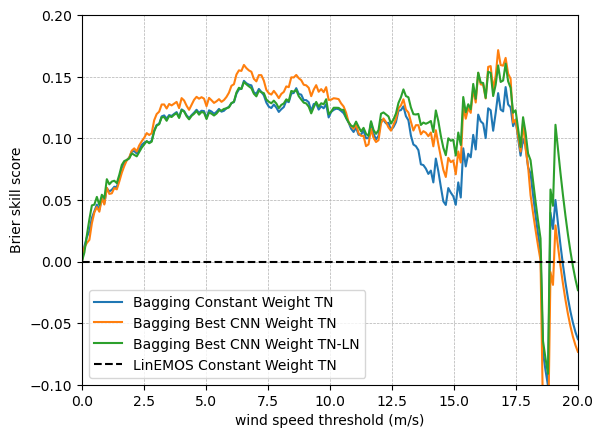

In [7]:
values = np.linspace(0,20,200)
ylim =[-0.1,0.2]
make_brier_skill_plot(constant_weight_tn, all_bagging_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

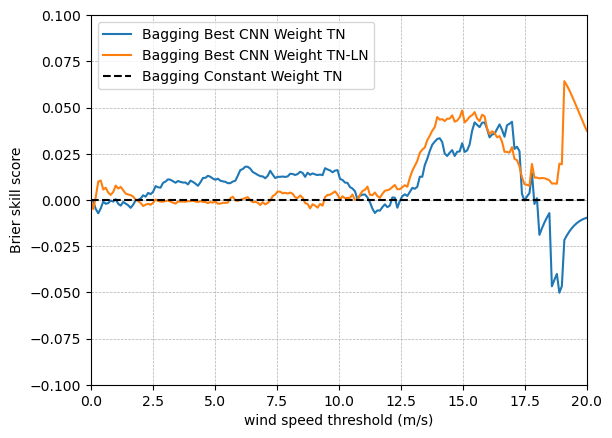

In [7]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

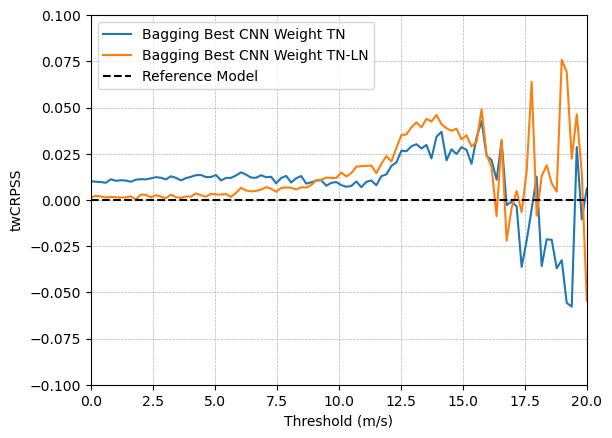

In [6]:
values = np.linspace(0,20,100)
ylim=[-0.1,0.1]
make_twcrpss_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values, ylim=ylim, sample_size=200)